In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

https://www.juntadeandalucia.es/organismos/saludyfamilias/actualidad/noticias.html

In [2]:
filename = 'covid19-es-and.csv'
fecha = '21/07/2020'
id_noticia = '240386'
url = 'https://www.juntadeandalucia.es/organismos/saludyfamilias/actualidad/noticias/detalle/' + id_noticia + '.html'

In [3]:
# Load
tables = pd.read_html(url, header=0, thousands='.')
assert len(tables) > 0
dfL = tables[0]

In [4]:
# Prepare
dfL['Fecha'] = fecha
# A partir del 14/05/2020 se cambia el formato del dato añadiendo en la misma columna el número de nuevos casos
for col in ['PCR Positivo',	'Hospitalización', 'UCI', 'Fallecimientos',	'Curados']:
    dfL[col] = dfL[col].str.split(' ').str[0]

dfL.tail(1)

,Provincia,PCR Positivo,Hospitalización,UCI,Fallecimientos,Curados,Fecha
8,Total,14.044,6.409,784,1.446,15.934,21/07/2020


In [5]:
data = pd.melt(dfL, id_vars=['Provincia', 'Fecha'])
# data.sample(5)

In [6]:
# Save to csv
data.to_csv(filename, encoding='utf-8', header=False, mode='+a', index=False)

In [7]:
# Load full csv
dfL = pd.read_csv(filename, thousands='.', parse_dates=['Fecha'], dayfirst=True)
# dfL.tail()

In [8]:
# Guardar el último día
last_fecha = dfL['Fecha'].max()

In [9]:
# Organizar en forma de tabla
df = pd.pivot_table(dfL, values='value', index=['Provincia', 'Fecha'], columns='variable')
df.sort_index(inplace=True)

In [10]:
# Variaciones con respecto al día anterior
dfV = df.groupby(level='Provincia').diff()
# dfV.tail()

In [11]:
# Para seleccionar todas las filas de una o varias fechas hay que usar un trick ya que : no se puede usar en este caso
dfG = dfV.loc[(slice(None), [last_fecha]), :]
dfG

,variable,Curados,Fallecimientos,Hospitalización,PCR Positivo,UCI
Provincia,Fecha,,,,,
Almería,2020-07-21,3.0,0.0,1.0,19.0,1.0
Cádiz,2020-07-21,3.0,0.0,3.0,5.0,0.0
Córdoba,2020-07-21,0.0,0.0,1.0,11.0,0.0
Granada,2020-07-21,4.0,0.0,0.0,11.0,0.0
Huelva,2020-07-21,1.0,0.0,0.0,1.0,0.0
Jaén,2020-07-21,0.0,0.0,0.0,0.0,0.0
Málaga,2020-07-21,23.0,0.0,2.0,23.0,0.0
Sevilla,2020-07-21,0.0,0.0,1.0,7.0,0.0
Total,2020-07-21,34.0,0.0,8.0,77.0,1.0


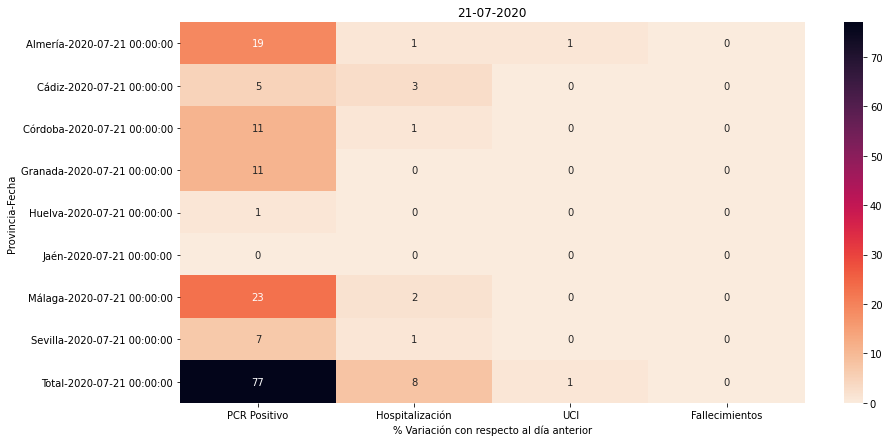

In [12]:
# Set the width and height of the figure
plt.figure(figsize=(14,7))

# Add title
plt.title(last_fecha.strftime('%d-%m-%Y'))

# Invertir los colores
cmap = sns.cm.rocket_r

# Heatmap 
sns.heatmap(data=dfG[['PCR Positivo', 'Hospitalización', 'UCI', 'Fallecimientos']], annot=True, cmap=cmap)

# Add label for horizontal axis
plt.xlabel('% Variación con respecto al día anterior')
plt.show()

In [13]:
provincia = 'Total'
dias = 15
# data = df.loc[provincia][['Hospitalización', 'Curados', 'Fallecimientos']].diff().tail(dias).copy()
data = df.loc[provincia].diff().tail(dias).copy()
titulo = 'Nuevos casos en los últimos ' + str(dias) + ' días en ' + provincia


In [14]:
print(titulo)
print(data)

Nuevos casos en los últimos 15 días en Total
variable    Curados  Fallecimientos  Hospitalización  PCR Positivo  UCI
Fecha                                                                  
2020-07-07     21.0             2.0              4.0          16.0  0.0
2020-07-08     48.0             0.0              2.0          26.0 -6.0
2020-07-09     46.0             2.0              4.0          34.0  0.0
2020-07-10     46.0             0.0              8.0          49.0  0.0
2020-07-11     60.0             0.0              6.0          62.0  2.0
2020-07-12      1.0             0.0              2.0          47.0  0.0
2020-07-13      0.0             0.0              5.0          18.0  1.0
2020-07-14     41.0             0.0             -1.0          28.0  0.0
2020-07-15     21.0             0.0              7.0          33.0  0.0
2020-07-16     28.0             0.0              2.0          90.0  1.0
2020-07-17     29.0             0.0              1.0          68.0  1.0
2020-07-18     26.0

Nuevos casos en los últimos 15 días en Total. (Nuevos positivos e ingresos hospitalarios)


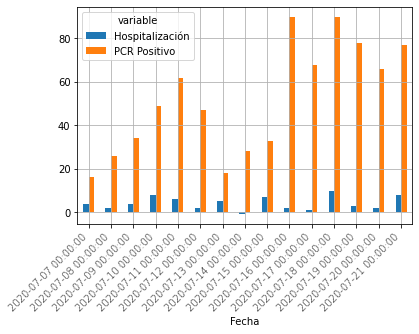

In [15]:
print(titulo + '. (Nuevos positivos e ingresos hospitalarios)')
data[['Hospitalización', 'PCR Positivo']].plot(kind='bar', grid=True)
plt.xticks(
    rotation=45,    
    horizontalalignment='right',
    fontweight='light',
)
plt.show()

In [16]:
# Fecha de último ingreso en hospital
data = df[['Hospitalización']].diff()
data = data[data['Hospitalización'] > 0].sort_index(ascending=False).groupby('Provincia').head(1).copy()
data.reset_index(inplace=True)
data['dias'] = pd.to_datetime(fecha, dayfirst=True) - data['Fecha']
data.set_index('Provincia', inplace=True)
data.sort_values('dias', ascending=False)

variable,Fecha,Hospitalización,dias
Provincia,,,
Huelva,2020-06-23,1.0,28 days
Jaén,2020-07-16,1.0,5 days
Granada,2020-07-19,1.0,2 days
Total,2020-07-21,8.0,0 days
Sevilla,2020-07-21,1.0,0 days
Málaga,2020-07-21,2.0,0 days
Córdoba,2020-07-21,1.0,0 days
Cádiz,2020-07-21,3.0,0 days
Almería,2020-07-21,1.0,0 days
